# An Example to test binary optimization with constraints

In [1]:
# Add PYOED source path to load source ahead of installed version
import sys, os
pyoed_path = os.path.abspath("../../../../")
print(pyoed_path)
if pyoed_path not in sys.path:
    sys.path.insert(0, pyoed_path)

/Users/attia/AHMED_HOME/Research/Projects/Software/PyOED/Forks/pyoed-oed.dev


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pyoed.optimization.binary_optimization import constrained_binary_optimization
from pyoed.optimization.optimization_utils import pseudo_random_binary_objective_function
from pyoed import utility
utility.plots_enhancer(fontsize=16, fontweight='normal')

In [3]:
def savefig(fig, saveto, dpi=600, format='pdf', close=False, ):
    format = format.lower().strip('. ')
    if not saveto.endswith(f".{format}"):
        saveto = f"{saveto}.{format}"

    # Create directory if not found
    fig_dir = os.path.abspath(os.path.dirname(saveto))
    if not os.path.isdir(fig_dir):
        os.makedirs(fig_dir)

    # Try to save the figure and raise propert exception if needed
    try:
        fig.savefig(saveto, bbox_inches='tight', dpi=dpi, format=format, )
        print(f"Saved plot to: {saveto}")
    except Exception as err:
        print(
            f"Failed to save the figure!"
            f"Unexpected {err=} of {type(err)=}"
        )
        raise
    else:
        if close:
            plt.close(fig)

In [4]:
def plot_surfaces(opt, approach=None, plot_stochastic_estimate=True, add_opt_traject=True, add_bruteforce=True, 
                 linewidth=2, markersize=6, saveto=None, 
                 ):
    """
    A function to update the optimizer constraint enforcement approach, solve the optimization problem and create a surface plot.
    """
    
    # Get current approach
    if approach is not None:
        current_approach = opt.budget_enforcement_approach
        opt.budget_enforcement_approach = approach
    
    print(f"opt.budget_enforcement_approach: {opt.budget_enforcement_approach}")
    print(f"opt.budget_sizes: {opt.budget_sizes}")    
    
    # Bruteforce search
    if add_bruteforce:
        bf = opt.bruteforce_objective_values()

    x = np.linspace(0, 1, 25)
    X, Y = np.meshgrid(x, x)

    # expectation surface
    stoch_obj_exact = np.empty_like(X)
    stoch_obj_random = np.empty_like(X)
    stoch_obj_exact[...] = np.nan
    stoch_obj_random[...] = np.nan

    print("Estimating stochastic Objective")
    for i in range(x.size):
        for j in range(x.size):
            print(f"\r{i*x.size+j}/{X.size}", end="")
            theta = [X[i, j], Y[i, j]]
            stoch_obj_exact[i, j] = opt.stochastic_policy_objective_value(theta, exact=True)
            if plot_stochastic_estimate:
                try:
                    stoch_obj_random[i, j] = opt.stochastic_policy_objective_value(theta, exact=False, sample_size=100, )
                except:
                    pass
    print("\nEstimating stochastic Objective done.")
    
    # Solve the optimization problem
    if add_opt_traject:
        results = opt.solve()
        traject = np.vstack(results['optimization_trajectory'])
        traject_objval = results['optimization_trajectory_stoch_objval']
    else:
        results = traject = traject_objval = None
    
    # Plot
    figsize = (14, 7) if plot_stochastic_estimate else (7, 7)
    fig = plt.figure(figsize=figsize)

    if plot_stochastic_estimate:
        ax = fig.add_subplot(121, projection="3d")
        ax.plot_surface(X, Y, stoch_obj_exact, alpha=0.65, )
        # 
        if add_opt_traject:
            ax.plot(traject[:, 0], traject[:, 1], traject_objval, '-kd', linewidth=linewidth, markersize=markersize, zorder=33)
            ax.scatter(traject[-1, 0], traject[-1, 1], traject_objval[-1], color='red', marker='x', s=20**2)
            
        if add_bruteforce:
            for k in bf.keys():
                d = opt.Bernoulli_random_sampler.index_to_binary_state(k).astype(int)
                ax.scatter(d[0], d[1], bf[k], s=10**2, )

            
        ax = fig.add_subplot(122, projection="3d")
        ax.plot_surface(X, Y, stoch_obj_random, alpha=0.65,)
        # 
        if add_opt_traject:
            ax.plot(traject[:, 0], traject[:, 1], traject_objval, '-kd', linewidth=linewidth, markersize=markersize, zorder=33)
            ax.scatter(traject[-1, 0], traject[-1, 1], traject_objval[-1], color='red', marker='x', s=20**2)
        
        if add_bruteforce:
            for k in bf.keys():
                d = opt.Bernoulli_random_sampler.index_to_binary_state(k).astype(int)
                ax.scatter(d[0], d[1], bf[k], s=10**2, )
        
    else:
        ax = fig.add_subplot(111, projection="3d")
        ax.plot_surface(X, Y, stoch_obj_exact, alpha=0.65,)
        # 
        if add_opt_traject:
            ax.plot(traject[:, 0], traject[:, 1], traject_objval, '-kd', linewidth=linewidth, markersize=markersize, zorder=33)
            ax.scatter(traject[-1, 0], traject[-1, 1], traject_objval[-1], color='red', marker='x', s=20**2)
            
        if add_bruteforce:
            for k in bf.keys():
                d = opt.Bernoulli_random_sampler.index_to_binary_state(k).astype(int)
                ax.scatter(d[0], d[1], bf[k], s=10**2, )
        
    if approach is not None:
        print(f"Approach: {approach}")
         
    if saveto is None:
        saveto = "3d_surface_plot"
        if add_opt_traject: saveto += "_with_optimization"
        if approach is not None: saveto += f"_{approach}"
    savefig(
        fig=fig, 
        saveto = saveto,
    )

    # Reset approach
    if approach is not None:
        opt.budget_enforcement_approach = current_approach
    return opt, results

## Define a two-dimentional objective function 

In [5]:
# Define a test objective function
random_seed = 234
objective = lambda x: pseudo_random_binary_objective_function(x, scale=100, random_seed=random_seed)
objective([1, 1])

50.19137228078792

## Define a constrianed binary optimizer

In [6]:
# define optimizer
opt = constrained_binary_optimization.ConstrainedBinaryReinforceOptimizer(
    {
        "obj_fun": objective,
        "size":2,
        "def_stepsize":0.005,
        "decay_step":False,
        "antithetic":True,
        "monitor_iterations":True,
        "baseline": "none", # NOTE: The optimal baseline formula is no longer correct because the variance there is calculated for no-constraints
    }
)

# Bruteforce search
bf = opt.bruteforce_objective_values()

## Plot the stochastic objective surface (no constraints)

### Brute-Force Search (Binary)

Design, obj:  [0 0] 45.08358657610159
Design, obj:  [1 0] 28.18784585905473
Design, obj:  [0 1] 29.868505428485438
Design, obj:  [1 1] 50.19137228078792
Saved plot to: binary_designs_bruteforce_2dproblem_3dscatter.pdf


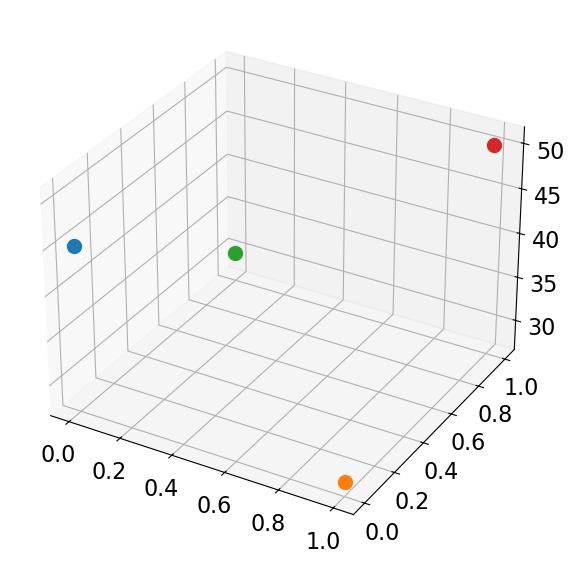

In [7]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

for k in bf.keys():
    d = opt.Bernoulli_random_sampler.index_to_binary_state(k).astype(int)
    print("Design, obj: ", d, bf[k])
    ax.scatter(d[0], d[1], bf[k], s=10**2, )

savefig(
    fig=fig, 
    saveto = "binary_designs_bruteforce_2dproblem_3dscatter.pdf",
    close=False,
)


In [8]:
### Stochastic Objective Surface

opt.budget_enforcement_approach: sum-as-variable
opt.budget_sizes: range(0, 3)
Estimating stochastic Objective
624/625
Estimating stochastic Objective done.
Approach: sum-as-variable
Saved plot to: 3d_surface_plot_sum-as-variable.pdf
opt.budget_enforcement_approach: sum-as-variable
opt.budget_sizes: range(0, 3)
Estimating stochastic Objective
624/625
Estimating stochastic Objective done.
REINFORCE Iteration: 1 ; Step-Update-Norm: 0.0983600598719603 


/Users/attia/AHMED_HOME/Research/Projects/Software/PyOED/Forks/pyoed-oed.dev/pyoed/optimization/binary_optimization/stochastic_binary_optimization.py:813: UserWarning: The best_along_the_route dictionary will not be built as the objective value tracker is populated beforehand.
 It must be initially empty (before starting the solution process) in order to find the best solution that has been explored so far.
  warnings.warn(


REINFORCE Iteration: 2 ; Step-Update-Norm: 0.04134616566982093 
REINFORCE Iteration: 3 ; Step-Update-Norm: 0.0766576073816256 
REINFORCE Iteration: 4 ; Step-Update-Norm: 0.11506861687720117 
REINFORCE Iteration: 5 ; Step-Update-Norm: 0.07130140720103247 
REINFORCE Iteration: 6 ; Step-Update-Norm: 0.06446440155235832 
REINFORCE Iteration: 7 ; Step-Update-Norm: 0.0836733195505957 
REINFORCE Iteration: 8 ; Step-Update-Norm: 0.18163185930725917 
REINFORCE Iteration: 9 ; Step-Update-Norm: 0.06400744649113428 
REINFORCE Iteration: 10 ; Step-Update-Norm: 0.08816458320650203 
REINFORCE Iteration: 11 ; Step-Update-Norm: 0.18271656160828204 
REINFORCE Iteration: 12 ; Step-Update-Norm: 0.11948177941559052 
REINFORCE Iteration: 13 ; Step-Update-Norm: 0.1138587799105262 
REINFORCE Iteration: 14 ; Step-Update-Norm: 0.09714607890979465 
REINFORCE Iteration: 15 ; Step-Update-Norm: 0.0 
Approach: sum-as-variable
Saved plot to: 3d_surface_plot_with_optimization_sum-as-variable.pdf


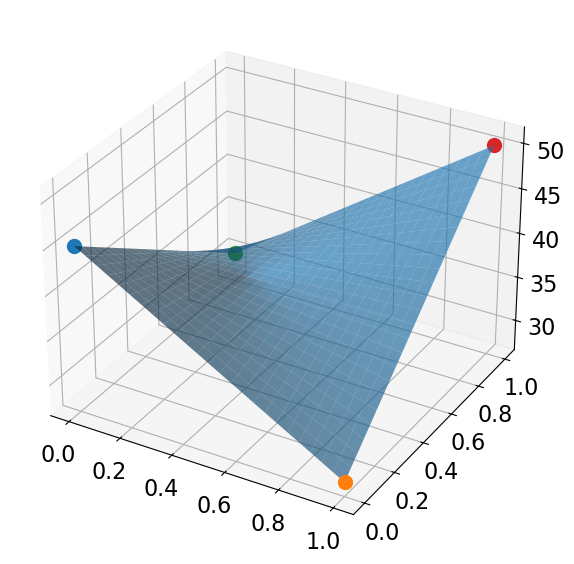

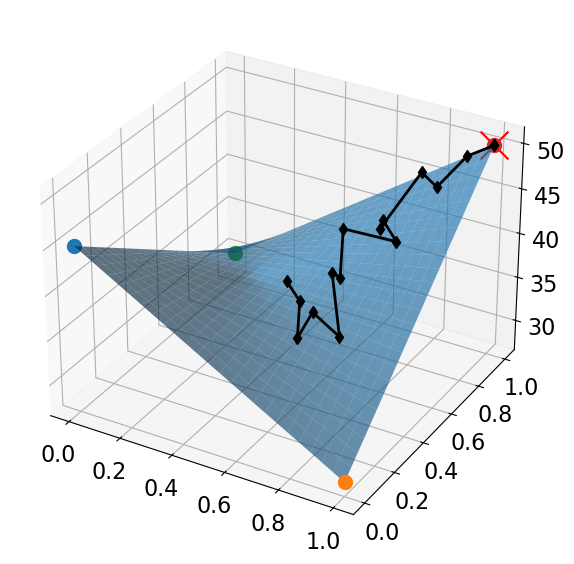

In [9]:
for add_opt in [False, True]:
    plot_surfaces(opt, approach='sum-as-variable', plot_stochastic_estimate=False, add_opt_traject=add_opt, add_bruteforce=True,)

## Test with a Budget Constraint (Upper Bound vs. Exact Budget)

### Upper Budget of 1 Active Sensor

In [10]:
_ = opt.register_budgets([1, 2])

#### 'modify-objective'

opt.budget_enforcement_approach: modify-objective
opt.budget_sizes: [1 2]
Estimating stochastic Objective
624/625
Estimating stochastic Objective done.
REINFORCE Iteration: 1 ; Step-Update-Norm: 0.19970265405064752 
REINFORCE Iteration: 2 ; Step-Update-Norm: 0.15604709466012218 
REINFORCE Iteration: 3 ; Step-Update-Norm: 0.23404233539839583 
REINFORCE Iteration: 4 ; Step-Update-Norm: 0.06843405248176933 
REINFORCE Iteration: 5 ; Step-Update-Norm: 0.04883613547952348 
REINFORCE Iteration: 6 ; Step-Update-Norm: 0.07977800255499368 
REINFORCE Iteration: 7 ; Step-Update-Norm: 0.08929939324526392 
REINFORCE Iteration: 8 ; Step-Update-Norm: 0.0 


/Users/attia/AHMED_HOME/Research/Projects/Software/PyOED/Forks/pyoed-oed.dev/pyoed/optimization/binary_optimization/stochastic_binary_optimization.py:813: UserWarning: The best_along_the_route dictionary will not be built as the objective value tracker is populated beforehand.
 It must be initially empty (before starting the solution process) in order to find the best solution that has been explored so far.
  warnings.warn(


Approach: modify-objective
Saved plot to: 3d_surface_plot_with_optimization_modify-objective.pdf


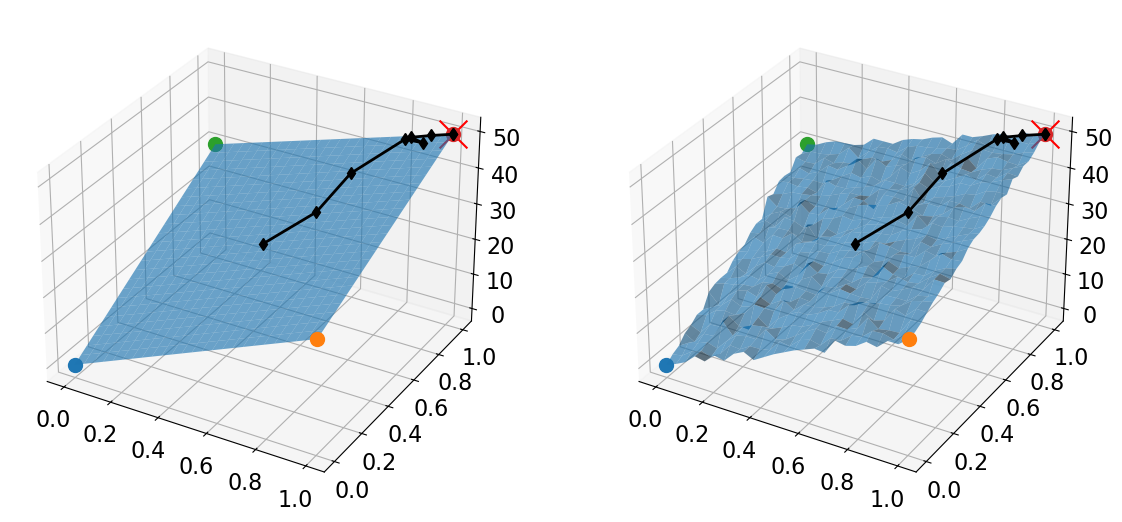

In [11]:
_ = plot_surfaces(opt, approach="modify-objective")

#### 'zero-probability'

opt.budget_enforcement_approach: zero-probability
opt.budget_sizes: [1 2]
Estimating stochastic Objective
624/625
Estimating stochastic Objective done.
REINFORCE Iteration: 1 ; Step-Update-Norm: 0.13769521355562253 
REINFORCE Iteration: 2 ; Step-Update-Norm: 0.2804066356088849 
REINFORCE Iteration: 3 ; Step-Update-Norm: 0.06665527354258077 
REINFORCE Iteration: 4 ; Step-Update-Norm: 0.18760859165397936 
REINFORCE Iteration: 5 ; Step-Update-Norm: 0.0410328738098763 
REINFORCE Iteration: 6 ; Step-Update-Norm: 0.0 


/Users/attia/AHMED_HOME/Research/Projects/Software/PyOED/Forks/pyoed-oed.dev/pyoed/optimization/binary_optimization/stochastic_binary_optimization.py:813: UserWarning: The best_along_the_route dictionary will not be built as the objective value tracker is populated beforehand.
 It must be initially empty (before starting the solution process) in order to find the best solution that has been explored so far.
  warnings.warn(


Approach: zero-probability
Saved plot to: 3d_surface_plot_with_optimization_zero-probability.pdf


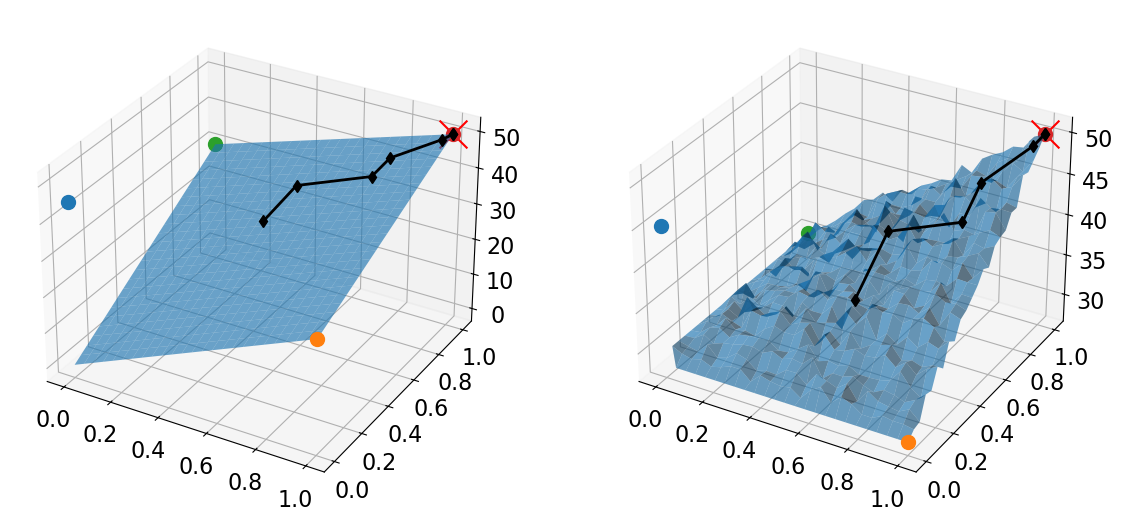

In [12]:
_ = plot_surfaces(opt, approach="zero-probability")

#### 'sampling-by-rejection'

opt.budget_enforcement_approach: sampling-by-rejection
opt.budget_sizes: [1 2]
Estimating stochastic Objective
624/625
Estimating stochastic Objective done.
REINFORCE Iteration: 1 ; Step-Update-Norm: 0.22250487112952883 
REINFORCE Iteration: 2 ; Step-Update-Norm: 0.2511155881915662 
REINFORCE Iteration: 3 ; Step-Update-Norm: 0.19852946692452966 
REINFORCE Iteration: 4 ; Step-Update-Norm: 0.1226704651313677 
REINFORCE Iteration: 5 ; Step-Update-Norm: 0.17235308495329849 
REINFORCE Iteration: 6 ; Step-Update-Norm: 0.01707182544991126 
REINFORCE Iteration: 7 ; Step-Update-Norm: 0.0 


/Users/attia/AHMED_HOME/Research/Projects/Software/PyOED/Forks/pyoed-oed.dev/pyoed/optimization/binary_optimization/stochastic_binary_optimization.py:813: UserWarning: The best_along_the_route dictionary will not be built as the objective value tracker is populated beforehand.
 It must be initially empty (before starting the solution process) in order to find the best solution that has been explored so far.
  warnings.warn(


Approach: sampling-by-rejection
Saved plot to: 3d_surface_plot_with_optimization_sampling-by-rejection.pdf


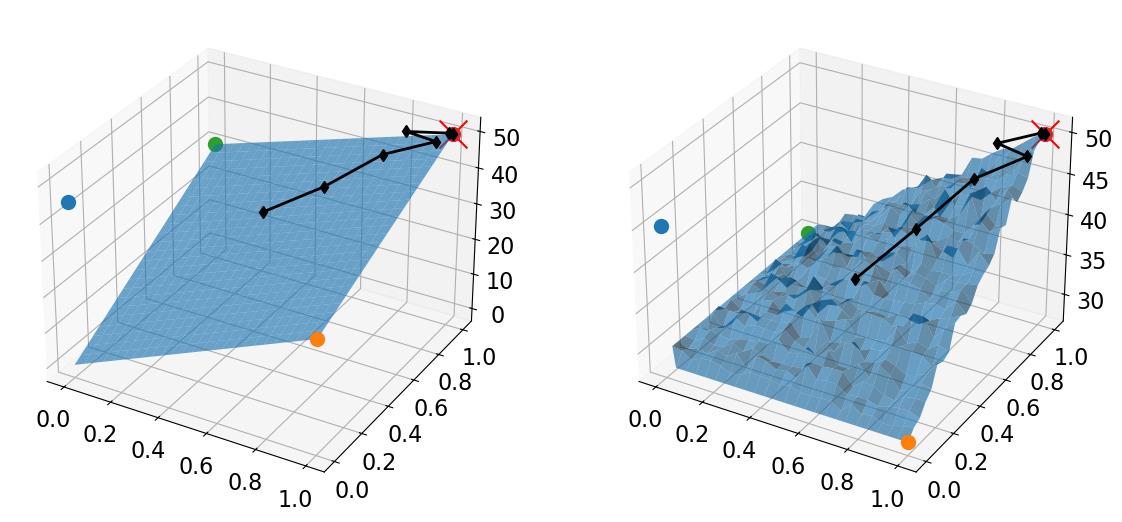

In [13]:
_ = plot_surfaces(opt, approach="sampling-by-rejection")

#### 'sampling-by-random-selection'

In [14]:
# _ = plot_surfaces(opt, approach="sampling-by-random-selection")

#### 'sum-as-variable'

opt.budget_enforcement_approach: sum-as-variable
opt.budget_sizes: [1 2]
Estimating stochastic Objective
624/625
Estimating stochastic Objective done.
REINFORCE Iteration: 1 ; Step-Update-Norm: 0.09222778948702513 
REINFORCE Iteration: 2 ; Step-Update-Norm: 0.11154108940987512 


/Users/attia/AHMED_HOME/Research/Projects/Software/PyOED/Forks/pyoed-oed.dev/pyoed/optimization/binary_optimization/stochastic_binary_optimization.py:813: UserWarning: The best_along_the_route dictionary will not be built as the objective value tracker is populated beforehand.
 It must be initially empty (before starting the solution process) in order to find the best solution that has been explored so far.
  warnings.warn(


REINFORCE Iteration: 3 ; Step-Update-Norm: 0.13798591469677798 
REINFORCE Iteration: 4 ; Step-Update-Norm: 0.10458042098787837 
REINFORCE Iteration: 5 ; Step-Update-Norm: 0.02914793890247651 
REINFORCE Iteration: 6 ; Step-Update-Norm: 0.11859555669450239 
REINFORCE Iteration: 7 ; Step-Update-Norm: 0.0977002402141643 
REINFORCE Iteration: 8 ; Step-Update-Norm: 0.1472729659236558 
REINFORCE Iteration: 9 ; Step-Update-Norm: 0.015185960005579258 
REINFORCE Iteration: 10 ; Step-Update-Norm: 0.0 
Approach: sum-as-variable
Saved plot to: 3d_surface_plot_with_optimization_sum-as-variable.pdf


array([ True,  True])

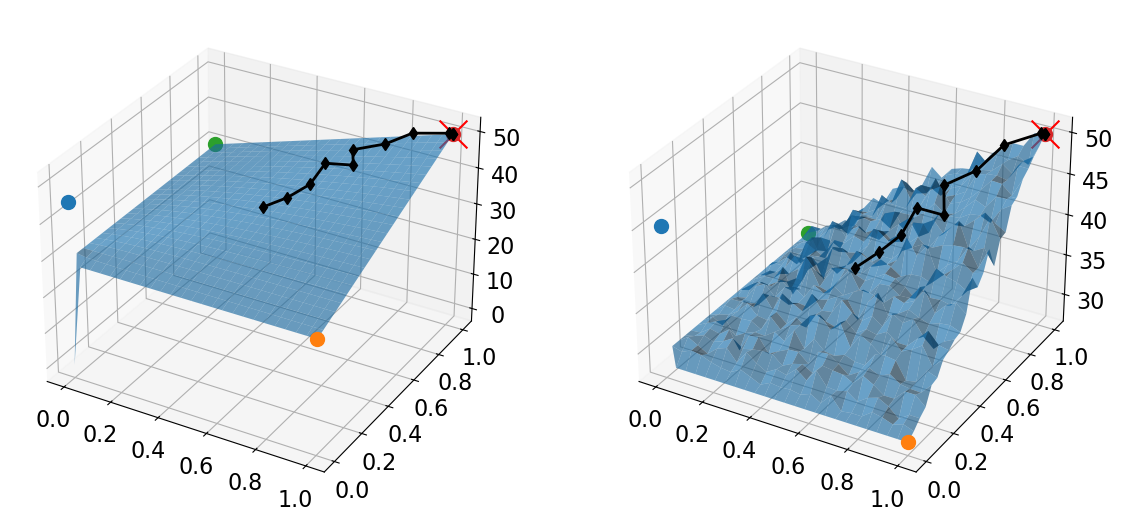

In [15]:
_ = plot_surfaces(opt, approach="sum-as-variable", )
_[1]['optimal_design']

### Exact Budget of 1 Active Sensor

In [16]:
_ = opt.register_budgets(1)

#### 'modify-objective'

opt.budget_enforcement_approach: modify-objective
opt.budget_sizes: [1]
Estimating stochastic Objective
624/625
Estimating stochastic Objective done.
REINFORCE Iteration: 1 ; Step-Update-Norm: 0.005199275280545976 
REINFORCE Iteration: 2 ; Step-Update-Norm: 0.015320295450389739 
REINFORCE Iteration: 3 ; Step-Update-Norm: 1.4440301329158017e-05 
REINFORCE Iteration: 4 ; Step-Update-Norm: 0.012820456907457848 
REINFORCE Iteration: 5 ; Step-Update-Norm: 0.00933344613911726 
REINFORCE Iteration: 6 ; Step-Update-Norm: 0.020857796277489918 


/Users/attia/AHMED_HOME/Research/Projects/Software/PyOED/Forks/pyoed-oed.dev/pyoed/optimization/binary_optimization/stochastic_binary_optimization.py:813: UserWarning: The best_along_the_route dictionary will not be built as the objective value tracker is populated beforehand.
 It must be initially empty (before starting the solution process) in order to find the best solution that has been explored so far.
  warnings.warn(


REINFORCE Iteration: 7 ; Step-Update-Norm: 0.025313727440073434 
REINFORCE Iteration: 8 ; Step-Update-Norm: 0.08373447854166581 
REINFORCE Iteration: 9 ; Step-Update-Norm: 0.10385481745436402 
REINFORCE Iteration: 10 ; Step-Update-Norm: 0.11093854775240669 
REINFORCE Iteration: 11 ; Step-Update-Norm: 0.17909392649037337 
REINFORCE Iteration: 12 ; Step-Update-Norm: 0.14065445375399263 
REINFORCE Iteration: 13 ; Step-Update-Norm: 0.0 
Approach: modify-objective
Saved plot to: 3d_surface_plot_with_optimization_modify-objective.pdf


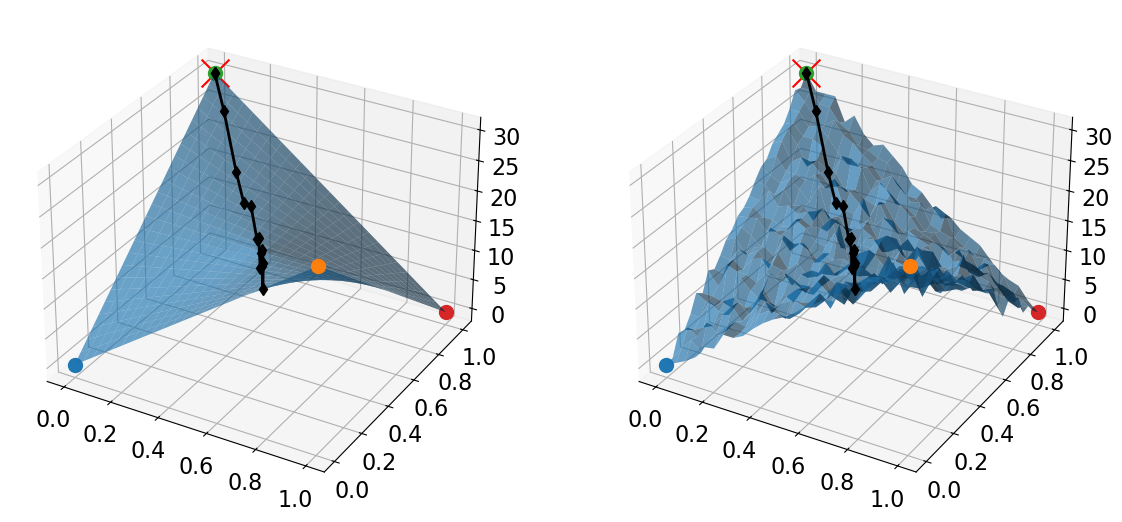

In [17]:
_ = plot_surfaces(opt, approach="modify-objective")

#### 'zero-probability'

opt.budget_enforcement_approach: zero-probability
opt.budget_sizes: [1]
Estimating stochastic Objective
624/625
Estimating stochastic Objective done.
REINFORCE Iteration: 1 ; Step-Update-Norm: 0.011884057784105177 
REINFORCE Iteration: 2 ; Step-Update-Norm: 0.004986015808046892 
REINFORCE Iteration: 3 ; Step-Update-Norm: 0.0020910988478625987 
REINFORCE Iteration: 4 ; Step-Update-Norm: 0.0521886347656673 
REINFORCE Iteration: 5 ; Step-Update-Norm: 0.047809491810102724 
REINFORCE Iteration: 6 ; Step-Update-Norm: 0.15136521077034565 
REINFORCE Iteration: 7 ; Step-Update-Norm: 0.18671489084065707 
REINFORCE Iteration: 8 ; Step-Update-Norm: 0.21332693111504855 
REINFORCE Iteration: 9 ; Step-Update-Norm: 0.036740449444711575 
REINFORCE Iteration: 10 ; Step-Update-Norm: 0.0 
Approach: zero-probability


/Users/attia/AHMED_HOME/Research/Projects/Software/PyOED/Forks/pyoed-oed.dev/pyoed/optimization/binary_optimization/stochastic_binary_optimization.py:813: UserWarning: The best_along_the_route dictionary will not be built as the objective value tracker is populated beforehand.
 It must be initially empty (before starting the solution process) in order to find the best solution that has been explored so far.
  warnings.warn(


Saved plot to: 3d_surface_plot_with_optimization_zero-probability.pdf


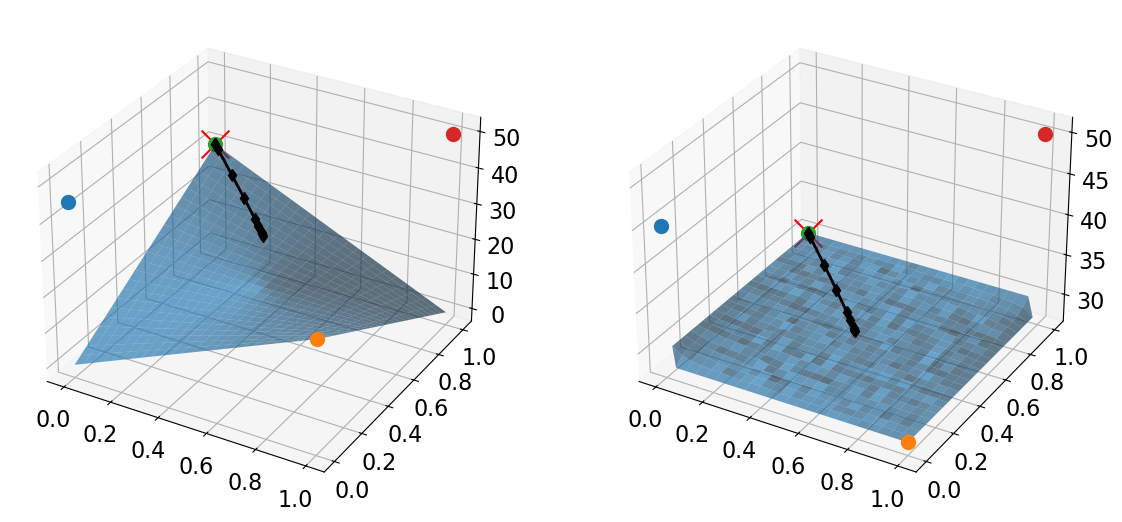

In [18]:
_ = plot_surfaces(opt, approach="zero-probability")

#### 'sampling-by-rejection'

opt.budget_enforcement_approach: sampling-by-rejection
opt.budget_sizes: [1]
Estimating stochastic Objective
624/625
Estimating stochastic Objective done.
REINFORCE Iteration: 1 ; Step-Update-Norm: 0.011884057784105177 
REINFORCE Iteration: 2 ; Step-Update-Norm: 0.030638303240038654 
REINFORCE Iteration: 3 ; Step-Update-Norm: 0.08997393462907659 
REINFORCE Iteration: 4 ; Step-Update-Norm: 0.06482948637108968 
REINFORCE Iteration: 5 ; Step-Update-Norm: 0.08184970851313493 
REINFORCE Iteration: 6 ; Step-Update-Norm: 0.21269498466439923 
REINFORCE Iteration: 7 ; Step-Update-Norm: 0.20040591411762973 
REINFORCE Iteration: 8 ; Step-Update-Norm: 0.014830391867073526 
REINFORCE Iteration: 9 ; Step-Update-Norm: 0.0 
Approach: sampling-by-rejection


/Users/attia/AHMED_HOME/Research/Projects/Software/PyOED/Forks/pyoed-oed.dev/pyoed/optimization/binary_optimization/stochastic_binary_optimization.py:813: UserWarning: The best_along_the_route dictionary will not be built as the objective value tracker is populated beforehand.
 It must be initially empty (before starting the solution process) in order to find the best solution that has been explored so far.
  warnings.warn(


Saved plot to: 3d_surface_plot_with_optimization_sampling-by-rejection.pdf


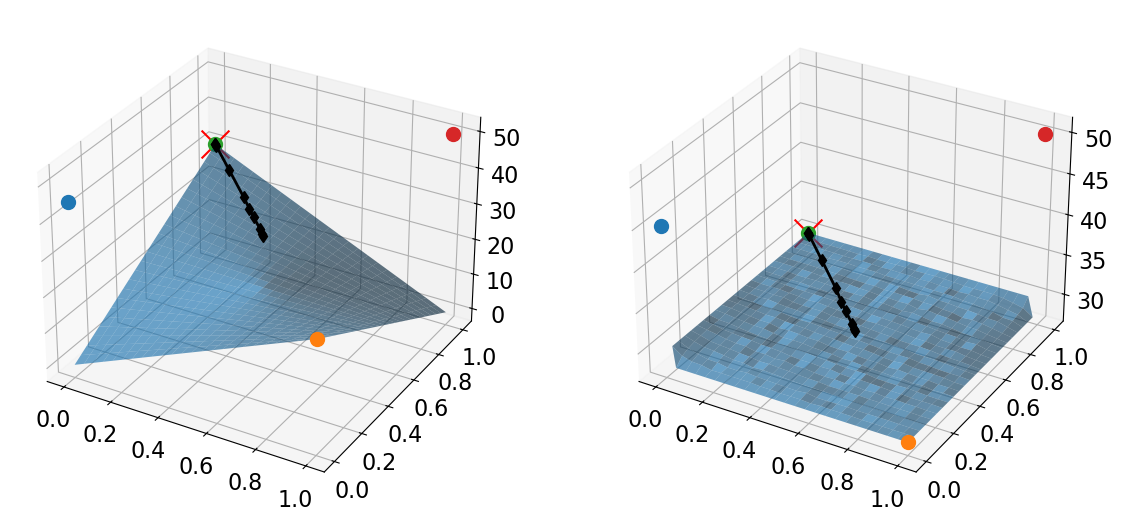

In [19]:
_ = plot_surfaces(opt, approach="sampling-by-rejection")

#### 'sampling-by-random-selection'

In [20]:
_ = plot_surfaces(opt, approach="sampling-by-random-selection")

opt.budget_enforcement_approach: sampling-by-random-selection
opt.budget_sizes: [1]
Estimating stochastic Objective
624/625
Estimating stochastic Objective done.


/Users/attia/AHMED_HOME/Research/Projects/Software/PyOED/Forks/pyoed-oed.dev/pyoed/optimization/binary_optimization/stochastic_binary_optimization.py:813: UserWarning: The best_along_the_route dictionary will not be built as the objective value tracker is populated beforehand.
 It must be initially empty (before starting the solution process) in order to find the best solution that has been explored so far.
  warnings.warn(


ValueError: Failed to sample a design with exact_budget=1;
Success probability has 2 non-zero entries.
Floating design=array([0., 0.])

#### 'sum-as-variable'

opt.budget_enforcement_approach: sum-as-variable
opt.budget_sizes: [1]
Estimating stochastic Objective
624/625
Estimating stochastic Objective done.
REINFORCE Iteration: 1 ; Step-Update-Norm: 0.1658292066079852 
REINFORCE Iteration: 2 ; Step-Update-Norm: 0.060654847546789396 
REINFORCE Iteration: 3 ; Step-Update-Norm: 0.11289575310715046 
REINFORCE Iteration: 4 ; Step-Update-Norm: 0.009696626712074354 
REINFORCE Iteration: 5 ; Step-Update-Norm: 0.0019184404640372789 
REINFORCE Iteration: 6 ; Step-Update-Norm: 0.03158112521811037 


/Users/attia/AHMED_HOME/Research/Projects/Software/PyOED/Forks/pyoed-oed.dev/pyoed/optimization/binary_optimization/stochastic_binary_optimization.py:813: UserWarning: The best_along_the_route dictionary will not be built as the objective value tracker is populated beforehand.
 It must be initially empty (before starting the solution process) in order to find the best solution that has been explored so far.
  warnings.warn(


REINFORCE Iteration: 7 ; Step-Update-Norm: 0.008124429318099534 
REINFORCE Iteration: 8 ; Step-Update-Norm: 0.0321533055218667 
REINFORCE Iteration: 9 ; Step-Update-Norm: 0.09063650701950215 
REINFORCE Iteration: 10 ; Step-Update-Norm: 0.03766645769073094 
REINFORCE Iteration: 11 ; Step-Update-Norm: 0.06998910343247293 
REINFORCE Iteration: 12 ; Step-Update-Norm: 0.019307958768036967 
REINFORCE Iteration: 13 ; Step-Update-Norm: 0.031136533091868222 
REINFORCE Iteration: 14 ; Step-Update-Norm: 0.062365462914178445 
REINFORCE Iteration: 15 ; Step-Update-Norm: 0.027903591155980918 
REINFORCE Iteration: 16 ; Step-Update-Norm: 0.031863986505580616 
REINFORCE Iteration: 17 ; Step-Update-Norm: 0.05160058145755699 
REINFORCE Iteration: 18 ; Step-Update-Norm: 0.05843986717606083 
REINFORCE Iteration: 19 ; Step-Update-Norm: 0.056871461292780014 
REINFORCE Iteration: 20 ; Step-Update-Norm: 0.014429936413119748 
REINFORCE Iteration: 21 ; Step-Update-Norm: 0.06590188651055622 
REINFORCE Iteration: 

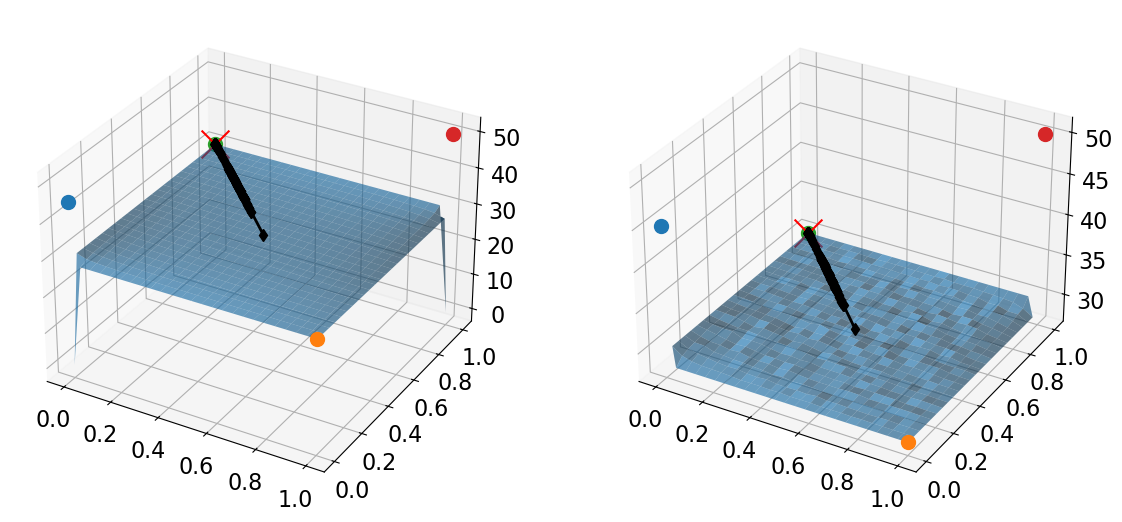

In [23]:
# No baseline
_, results = plot_surfaces(opt, "sum-as-variable", )

opt.budget_enforcement_approach: sum-as-variable
opt.budget_sizes: [1]
Estimating stochastic Objective
624/625
Estimating stochastic Objective done.
REINFORCE Iteration: 1 ; Step-Update-Norm: 0.017689186083785988 
REINFORCE Iteration: 2 ; Step-Update-Norm: 0.06623282375563848 
REINFORCE Iteration: 3 ; Step-Update-Norm: 0.11011256169409056 


/Users/attia/AHMED_HOME/Research/Projects/Software/PyOED/Forks/pyoed-oed.dev/pyoed/optimization/binary_optimization/stochastic_binary_optimization.py:813: UserWarning: The best_along_the_route dictionary will not be built as the objective value tracker is populated beforehand.
 It must be initially empty (before starting the solution process) in order to find the best solution that has been explored so far.
  warnings.warn(


REINFORCE Iteration: 4 ; Step-Update-Norm: 0.019114676667732925 
REINFORCE Iteration: 5 ; Step-Update-Norm: 0.07458335098885784 
REINFORCE Iteration: 6 ; Step-Update-Norm: 0.0026862612645011112 
REINFORCE Iteration: 7 ; Step-Update-Norm: 0.006685148059771603 
REINFORCE Iteration: 8 ; Step-Update-Norm: 0.07477545670845141 
REINFORCE Iteration: 9 ; Step-Update-Norm: 0.013133652444564268 
REINFORCE Iteration: 10 ; Step-Update-Norm: 0.014666088917213682 
REINFORCE Iteration: 11 ; Step-Update-Norm: 0.07459290740661403 
REINFORCE Iteration: 12 ; Step-Update-Norm: 0.030243326096032908 
REINFORCE Iteration: 13 ; Step-Update-Norm: 0.026189470219038294 
REINFORCE Iteration: 14 ; Step-Update-Norm: 0.06928606997350925 
REINFORCE Iteration: 15 ; Step-Update-Norm: 0.007247975137011883 
REINFORCE Iteration: 16 ; Step-Update-Norm: 0.013612611195206969 
REINFORCE Iteration: 17 ; Step-Update-Norm: 0.05751639063998352 
REINFORCE Iteration: 18 ; Step-Update-Norm: 0.04609849806547478 
REINFORCE Iteration: 

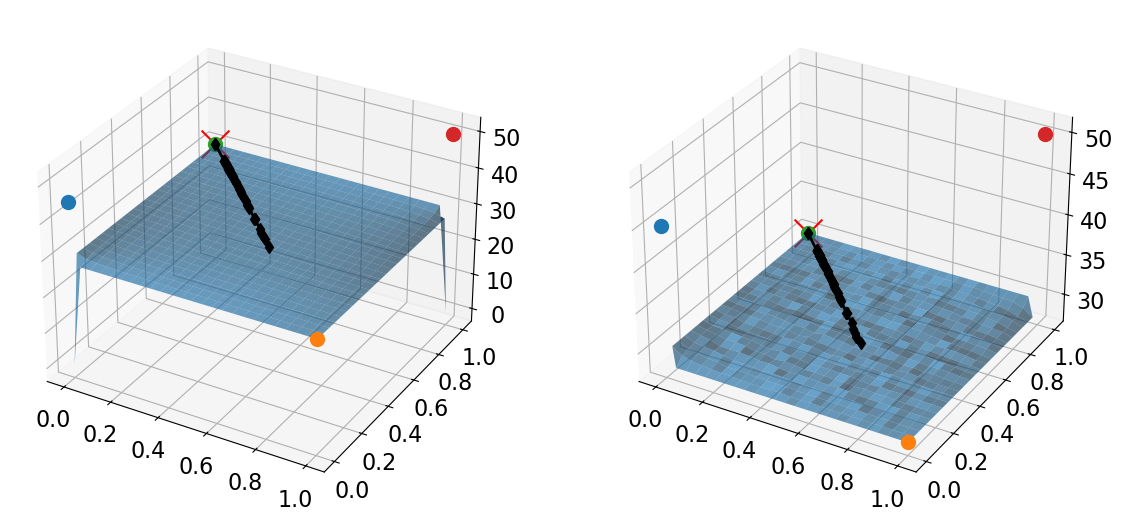

In [24]:
# Optimal baseline
opt.update_configurations(baseline='optimal',)
_, results = plot_surfaces(opt, "sum-as-variable")
opt.update_configurations(baseline="none", )